<a href="https://colab.research.google.com/github/sunnyzyr/cse455-SVHN/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image

# make sure to use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# connect to google drive and make checkpoints
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/final_project/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/colab_files/final_project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def get_SVHN_data(augmentation=0):
  # Data augmentation transformations.
  if augmentation:
    transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4, padding_mode='edge'), # Take 32x32 crops from 40x40 padded images
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.ToTensor(),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
  ])

  trainset = torchvision.datasets.SVHN(root='./data', split='train',
                                          download=True, transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.SVHN(root='./data', split='test',
                                         download=True, transform=transform_test) 
  testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                           shuffle=False, num_workers=2)

  classes = range(10)
  return {'train':trainloader,'test':testloader,'classes':classes}
  

data = get_SVHN_data()


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
# test whether the data is downloaded successfully
# it should return the size for train = 73257, size of test = 26032
print(data['train'].__dict__)
print(data['test'].__dict__)

torch.Size([8, 3, 32, 32])


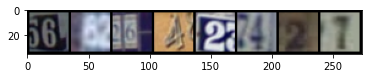

Labels:        6,         8,         6,         4,         2,         4,         2,         7
torch.Size([8, 3, 32, 32])
torch.Size([8, 3072])


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['classes'][labels[j].item()] for j in range(8)))
flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

### **Defining networks**

This model was revised from [tutorial 3](https://colab.research.google.com/drive/1EBz4feoaUvz-o_yeMI27LEQBkvrXNc_4?usp=sharing#scrollTo=76z4UJgTR13J). It has four convolutional layers, maxpooling, a global average pooling and fully connected layer.
We also use batch normalization.


In [ ]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__() 

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        # Input 32x32x3

        # x = self.conv1(x)
        # x = self.bn1(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 16x16x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 8x8x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 4x4x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 2x2x128

        # Global average pooling across each channel (Input could be 2x2x256, 4x4x256, 7x3x256, output would always be 256 length vector)
        x = F.adaptive_avg_pool2d(x, 1) # size(x) = [128, 128, 1, 1]               # 1x1x128
        x = torch.flatten(x, 1)         # size(x) = [128, 128]                     # vector 128
        
        x = self.fc1(x)
        return x

In [17]:
class RevisedCNN(nn.Module):
    def __init__(self):
        super(RevisedCNN, self).__init__() 

        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(4*4*256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )


    def forward(self, x):
        return self.network(x)

## Training
ALso add a schedule parameter to handle learning rate scheduling and a checkpoint_path parameter which will be where training checkpoints are saved (if provided).

In [15]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Testing
For the first model

In [ ]:
net = ComplexCNN()
losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:.001}, checkpoint_path=checkpoints)

Testing  accuracy: 0.761409


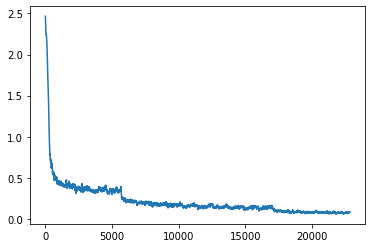

In [ ]:
plt.plot(smooth(losses,50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

Transfer learning with SHVN, training with pretrained weights

In [ ]:
pretrain_net = ComplexCNN()

# Load weights from pretrained model
state = torch.load(checkpoints + 'checkpoint-19.pkl')
output = pretrain_net.load_state_dict(state['net'], strict=False)

pretrain_losses = train(pretrain_net, data['train'], epochs=20, schedule={0:.01, 5:.001, 10:.0001}, checkpoint_path=checkpoints)
print("Testing accuracy: %f" % accuracy(pretrain_net, data['test']))
plt.plot(smooth(pretrain_losses,50))

Testing accuracy from scratch: 0.761409
Testing accuracy pretrained  : 0.747734


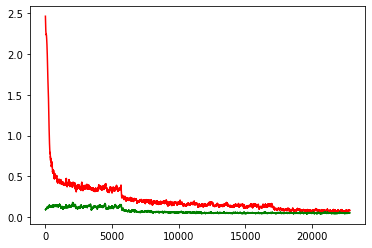

In [ ]:
print("Testing accuracy from scratch: %f" % accuracy(net, data['test']))
print("Testing accuracy pretrained  : %f" % accuracy(pretrain_net, data['test']))

plt.plot(smooth(losses,50), 'r-')
plt.plot(smooth(pretrain_losses,50),'g-')

For the second model

In [ ]:
net = RevisedCNN()

losses = train(net, data['train'], epochs=20, schedule={0:.1, 5:.01, 15:0.0001}, checkpoint_path=checkpoints)

test accuracy: 0.928204


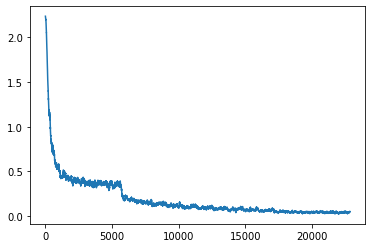

In [ ]:
plt.plot(smooth(losses, 50))
print("test accuracy: %f" % accuracy(net, data['test']))

In [19]:
torch.save(net, checkpoints + "RevisedCNN.pth")

In [ ]:
!pip install Gradio


In [ ]:
import gradio as gr
from matplotlib import cm

In [ ]:
# testing single images
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

net_use = torch.load(checkpoints + "RevisedCNN.pth", map_location=torch.device('cpu'))

transforms_use = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

net_use.to('cpu')
net_use.eval()


In [ ]:
def classify(img):
    image = Image.fromarray(img.astype('uint8'), 'RGB')
    # image = Image.open(img)
    image = transforms_use(image).float()
    image = image.unsqueeze(0)
    with torch.no_grad():
      out = net_use(image)
      probabilities = torch.nn.functional.softmax(out[0], dim=0)
      values, indices = torch.topk(probabilities, 5)
      confidences = {classes[i]: v.item() for i, v in zip(indices, values)}
    return confidences

# img = open(checkpoints + "three.png", 'rb')
# classify(img)

In [21]:

label = gr.outputs.Label(num_top_classes=3)
rgb_pad = gr.Image(image_mode='RGB', source='canvas', shape=(32, 32), invert_colors=True)

interface = gr.Interface(fn=classify, inputs=rgb_pad, outputs=label, live=True).launch(debug=True)


/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Hint: Set streaming=True for Image component to use live streaming.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://11712.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
